## HW4

## Q2: Implement the double Q-learning algorithm on the Cliff Walking example (5%)

The double Q-learning algorithm is a variant of the standard Q-learning algorithm, specifically designed to mitigate the maximization bias (see Pages 39 - 40 on Lecture 4) commonly encountered in the traditional tabular Q-learning approach. The core idea of this algorithm is outlined as follows:

<img src="./graphs/double_q_learning.png" width="750" height="450">

See Pages 39 -- 42 on Lecture 4 for the detailed explanation. The pseudo code of this algorithm is given on Page 42. 

#### Task: Implment the double Q-learning algorithm on Cliff Walking (refer to Page 42 of Lecture 4 for the pseudocode)
- Set the number of runs to 10
- Set the number of episodes to 1000
- Set the learning rate $\alpha$ to 0.1
- Set the discount factor $\gamma$ to 1
- Output the estimated optimal policy
- Plot the average return during episodes, aggregated over 10 runs (see the plot in Seminar 4)

In [1]:
# Candidate number: 22137

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(1)

In [3]:
### No modifications to this part (seminars code)
class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state

In [4]:
### No modification to epsilon greedy policy 
def eps_greedy_policy(qsa, epsilon = 0.10):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])

### The rule is updated for Double Q-learning

# qsa is the state-action value of the actual state
# qs_next is a vector with the action values of the next state
# qs_double is a vector with the action values of the next state of the OTHER q function
def q_learning(qsa, qs_next, qs_double, r, alpha = 0.1, gamma = 1.0):
    # retrieves action with maximum value
    action_double = np.random.choice([action_ for action_, value_ in enumerate(qs_next) if value_ == np.max(qs_next)])
    
    # Update rule
    return (qsa + alpha * (r + gamma * qs_double[action_double] - qsa))

In [5]:
### Nothing changes here from seminars code
start_position = [3, 0]  
goal = [3, 11]
world_width = 12
world_height = 4 
# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

In [6]:
env_q_learning = CliffWalking(start_position, goal)

runs = 10
episodes = 1000
rewards_qlearning = np.zeros(episodes)

for r in range(runs):
    # Now we have two q functions
    q_qlearning1 = np.zeros((world_height, world_width, len(actions)))
    q_qlearning2 = np.zeros((world_height, world_width, len(actions)))
    
    
    for i in range(episodes):
        state_q = env_q_learning.reset()
        done_q = False
        g_q = 0.0
        
        # Double Q-Learning
        while not done_q:
            row_q, col_q = state_q
            
            # The sum of the two action values for the actual state
            tot_q = q_qlearning1[row_q, col_q, :] + q_qlearning2[row_q, col_q, :]
            
            # epsilon greedy policy receives now the sum of the two qfunctions for the actual state
            a_q = eps_greedy_policy(tot_q)

            next_state_q, r_q, done_q = env_q_learning.step(a_q)
            g_q += r_q

            # Q-learning updates
            n_row_q, n_col_q = next_state_q
            
            
            # Flip a coin (Double Q-learning) to check which of the two q functions is updated
            if np.random.binomial(1, p=0.5) == 1:
                q_qlearning1[row_q, col_q, a_q] = q_learning(q_qlearning1[row_q, col_q, a_q], 
                                                             q_qlearning1[n_row_q, n_col_q, :], 
                                                             q_qlearning2[n_row_q, n_col_q, :], r_q)
            else:
                q_qlearning2[row_q, col_q, a_q] = q_learning(q_qlearning2[row_q, col_q, a_q], 
                                                             q_qlearning2[n_row_q, n_col_q, :], 
                                                             q_qlearning1[n_row_q, n_col_q, :], r_q)
                
            state_q = next_state_q
            
        rewards_qlearning[i] += g_q

In [7]:
def print_optimal_policy(policy, method):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11): 
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print(method + ' Optimal policy is:')
    for row in policy_display:
        print(row)
        
q_qlearning = q_qlearning1 + q_qlearning2
optimal_policy = np.argmax(q_qlearning, axis=2)
print_optimal_policy(optimal_policy, 'Q-Learning')

Q-Learning Optimal policy is:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['R' 'U' 'U' 'R' 'U' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'U' 'U' 'U' 'L' 'R' 'U' 'R' 'R' 'U' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']


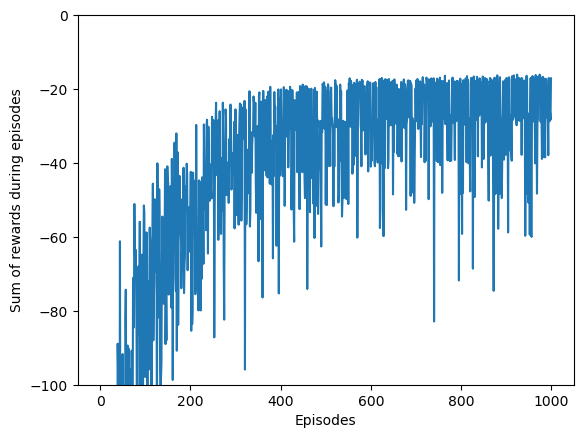

In [8]:
rewards_qlearning /= runs

plt.figure()
method, method_title = rewards_qlearning, 'Q-learning'
plt.plot(method)
plt.title=method_title
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episodes')
plt.ylim([-100, 0])
plt.show()

Notice that if one increases the $\epsilon$ parameter in the $\epsilon$-greedy policy, we obtain the optimal policy but the rewards vary way more:

In [9]:
env_q_learning = CliffWalking(start_position, goal)

runs = 10
episodes = 1000
rewards_qlearning = np.zeros(episodes)

for r in range(runs):
    # Now we have two q functions
    q_qlearning1 = np.zeros((world_height, world_width, len(actions)))
    q_qlearning2 = np.zeros((world_height, world_width, len(actions)))
    
    
    for i in range(episodes):
        state_q = env_q_learning.reset()
        done_q = False
        g_q = 0.0
        
        # Double Q-Learning
        while not done_q:
            row_q, col_q = state_q
            
            # The sum of the two action values for the actual state
            tot_q = q_qlearning1[row_q, col_q, :] + q_qlearning2[row_q, col_q, :]
            
            # epsilon greedy policy receives now the sum of the two qfunctions for the actual state
            a_q = eps_greedy_policy(tot_q, epsilon = 0.3)

            next_state_q, r_q, done_q = env_q_learning.step(a_q)
            g_q += r_q

            # Q-learning updates
            n_row_q, n_col_q = next_state_q
            
            
            # Flip a coin (Double Q-learning) to check which of the two q functions is updated
            if np.random.binomial(1, p=0.5) == 1:
                q_qlearning1[row_q, col_q, a_q] = q_learning(q_qlearning1[row_q, col_q, a_q], 
                                                             q_qlearning1[n_row_q, n_col_q, :], 
                                                             q_qlearning2[n_row_q, n_col_q, :], r_q)
            else:
                q_qlearning2[row_q, col_q, a_q] = q_learning(q_qlearning2[row_q, col_q, a_q], 
                                                             q_qlearning2[n_row_q, n_col_q, :], 
                                                             q_qlearning1[n_row_q, n_col_q, :], r_q)
                
            state_q = next_state_q
            
        rewards_qlearning[i] += g_q

In [10]:
def print_optimal_policy(policy, method):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11): 
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print(method + ' Optimal policy is:')
    for row in policy_display:
        print(row)
        
q_qlearning = q_qlearning1 + q_qlearning2
optimal_policy = np.argmax(q_qlearning, axis=2)
print_optimal_policy(optimal_policy, 'Q-Learning')

Q-Learning Optimal policy is:
['D' 'D' 'D' 'D' 'D' 'D' 'R' 'R' 'D' 'R' 'R' 'D']
['D' 'D' 'D' 'D' 'D' 'D' 'R' 'R' 'D' 'D' 'R' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']


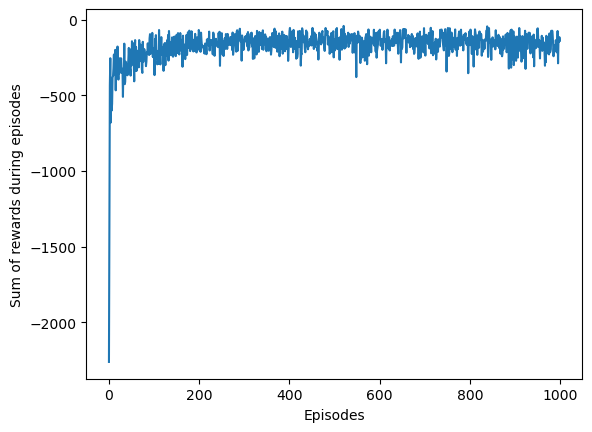

In [12]:
rewards_qlearning /= runs

plt.figure()
method, method_title = rewards_qlearning, 'Q-learning'
plt.plot(method)
plt.title=method_title
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episodes')
#plt.ylim([-100, 0])
plt.show()

Notice that in this second plot, the rewards vary significantly more than in the previous case, but we obtain the optimal policy. Whereas in the first plot the reward vary less more but we obtain a "safer" policy in most cases